# <strong> Example battery design: Automating BatPaC V5</strong>
   

The following notebook provides an example of the battery design module. The module uses BatPaC version 5 to solve the battery design based on user specific parameters and returns the material content of specific battery design. The notebook contains three examples:

* Example 1: Single battery design
* Example 2: Including vehicle parameters
* Example 3: Several battery designs



<center><img src='../docs/batpac_python.png' width=800/></center>

In [1]:
#Import required packages

import pandas as pd
import sys
import matplotlib.pyplot as plt
from tabulate import tabulate


#Import the battery design module from a local path
sys.path.insert(1, r'C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model\batt_sust_model')
from battery_design import battery_design as bd

#Local Path to BatPaC version 5. 
# Make sure iterative calculations are enabled (100 iterations is sufficient, see BatPaC manual 3rd edition page 12):
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 10Feb2022.xlsm"

## Example 1 - Solving a single battery pack design
The geometric design of the Volkswagen MEB platform, 77 kWh version as reported by
[PushEVS.com](https://pushevs.com/2020/05/13/volkswagen-meb-details/) is used as an example (NMC622 is used instead of NMC712, as the latter is not in the public version of BatPaC V5l). All other parameters are BatPaC default parameters.

* usable battery energy: 94%
* Total pack energy: 82 kWh
* Electrode pair: NMC622-G
* Silicon additive anode: 0%
* Cells per module: 24
* Modules per pack: 12
* Modules in parallel: 2 
* Cooling: liquid
* Maximum charging time: 33 minutes (ev-database.org)
* Maximum charge power: 135 kW (ev-database.org)
<br>

<!-- <a href=https://www.volkswagen-newsroom.com/en/press-releases/long-range-and-rapid-charging-the-battery-system-is-at-the-heart-of-the-volkswagen-id3-id4-and-id4-gtx-7130>
<center><img src='../docs/ID pack.jpg' width=600/> <br></center>
<figcaption align = "center"><b>Structure of the Volkswagen MEB platform (VW, 2021) </b></figcaption>
</a> -->

In [21]:
#Establish battery system class of specific design:
battery = bd.Battery_system ( vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)', 
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             cells_in_parallel=1,
                             silicon_anode= 0.00, 
                             pack_energy=82, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94)
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background. 
# #BatPaC can run in the foreground if visible=True
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

In [22]:
from tabulate import tabulate

headers = [' ', 'BatPaC output', 'VW ID3.']
data = [['Usable capacity (kWh)', result_dict['general_battery_parameters']['pack_usable_energy_kWh'], 77],
        ['Batter weight (kg)', round(result_dict['material_content_pack']['battery pack'],1),493],
        ['Pack energy density Wh/kg', round(result_dict['general_battery_parameters']['pack_energy_kWh']/result_dict['material_content_pack']['battery pack'],4)*1000, 166.3],
        ['Cell weight (kg)', round(result_dict['material_content_pack']['cell']/result_dict['general_battery_parameters']['cells_per_pack'],3),1.073],
        ['Cell capacity (Ah)',round(result_dict['general_battery_parameters']['cell_capacity_ah'], 2),78],
        ['Total cells',result_dict['general_battery_parameters']['cells_per_pack'],288],
        ['Cell energy density (Wh/kg)', result_dict['general_battery_parameters']['specific_energy_cell_Wh/kg'],265]
       ]

print ('Results modelled pack versus VW3 ID3. Data based on PushEV and EPA "Application for Emissions Certification" for ID.4 (same pack):')
print(tabulate(data, headers=headers, numalign="right"))


Results modelled pack versus VW3 ID3. Data based on PushEV and EPA "Application for Emissions Certification" for ID.4 (same pack):
                               BatPaC output    VW ID3.
---------------------------  ---------------  ---------
Usable capacity (kWh)                  77.08         77
Batter weight (kg)                     519.7        493
Pack energy density Wh/kg              157.8      166.3
Cell weight (kg)                       0.917      1.073
Cell capacity (Ah)                     77.62         78
Total cells                              288        288
Cell energy density (Wh/kg)          310.424        265


### Export to Excel
Results can be exported to Excel, resulting in two files: 
* 3_MC_battery_pack_materials: the material content of the battery design
* 3_PAR_battery_design parameters:  includes the design parameters and several technical parameters


In [144]:
bd.export_to_excel(result_dict, 'result_1')

## Example 2 - Including vehicle parameters


An additional vehicle model is included to calculate the required battery energy for specific vehicle parameters and a desired range. The model and interaction with BatPaC is based on a the study by [Yelin et al., 2017](https://www.sciencedirect.com/science/article/abs/pii/S0378775317300368) and [Kim and Wallington, 2016](https://pubs.acs.org/doi/10.1021/acs.est.6b02059). 

<img src='../docs/batpac_vehicle_model.png' width=600/>



Several input parameters that **need** to be defined. This includes the desired vehicle range in miles and the rolling resistance coefficient, rotation resistance coefficient and aerodynamic resistance coefficient, also referred to as the A, B, and C target coefficients, respectively. The target coefficients are based on the EPA vehicle testing data used to determine the fuel economy of new vehicles. Annual data can be found [here](https://www.epa.gov/compliance-and-fuel-economy-data/data-cars-used-testing-fuel-economy). 

In the following example, the target coefficients and range of the VW ID.4 are used to model the corresponding battery and vehicle size in BatPaC and the vehicle model. 




In [23]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                             vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)', 
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             cells_in_parallel=1,
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 34,  #EV-database https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             max_charge_power = 126,  #EV-database https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range=410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150 #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/autokatalog/marken-modelle/vw/id4/1generation/318521/#technische-daten                 
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()



In [24]:
#With all vehicle parameters defined, a new vehicle sheet in added in BatPaC.
#Several functions in BatPaC are changed such that the vehicle range determines the kWh (originally removed from BatPaC V5)
#Make sure BatPaC is closed
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

In [25]:
headers = [' ', 'Modelled', 'VW ID4. Pro']
data = [['Usable capacity (kWh)', round(result_dict['general_battery_parameters']['pack_usable_energy_kWh'],0), 77],
        ['Vehicle weight (kg)', round(result_dict['general_battery_parameters']['vehicle_weight'],0),2124 ],
        ['Battery weight (kg)', round(result_dict['material_content_pack']['battery pack'],0),493],
        ['Pack energy density Wh/kg', round(result_dict['general_battery_parameters']['pack_energy_kWh']/result_dict['material_content_pack']['battery pack'],4)*1000, 166.3],
        ['Cell weight (kg)', round(result_dict['material_content_pack']['cell']/result_dict['general_battery_parameters']['cells_per_pack'],3),1.073],
        ['Glider weight (kg)', round(result_dict['general_battery_parameters']['glider_weight'],1),  0],
        ['Motor weight (kg)', round(result_dict['general_battery_parameters']['motor_controller_weight'],0), 0 ],
        ['Transmission weight (kg)', round(result_dict['general_battery_parameters']['transmission_weight'],0), 0 ],
       ]

print ('Results modelled vehicle versus VW ID4 Pro (reported weight based on adac.de):')
print(tabulate(data, headers=headers, numalign="right"))

Results modelled vehicle versus VW ID4 Pro (reported weight based on adac.de):
                             Modelled    VW ID4. Pro
-------------------------  ----------  -------------
Usable capacity (kWh)              84             77
Vehicle weight (kg)              2216           2124
Battery weight (kg)               545            493
Pack energy density Wh/kg         163          166.3
Cell weight (kg)                0.981          1.073
Glider weight (kg)               1382              0
Motor weight (kg)                 175              0
Transmission weight (kg)          114              0


## Example 3 - Solving multiple battery designs
In the following example, the battery design module is used to iterate through several design parameters and solve the battery system for several batteries. Using the function 'solve_batpac_battery_system_multiple', BatPaC does not close and solves for each design parameter (takes a few second to solve BatPaC in Excel with 100 iterations per calculation enabled). 

In the following example the model iterates through different cathode chemistries and current collector thickness:

* cathode chemistry: NMC622-G and NMC811-G
* anode current collector thickness: 6 and 8
* cathode current collector thickness: 10 and 12
 <br>



In [5]:
import itertools as itertools

cathode_chemistry         = ['NMC622-G (Energy)', 'NMC811-G (Energy)']
anode_current_collector   = [6, 8]
cathode_current_collector = [10,12]

dict_design = {}

param_all = list(itertools.product(cathode_chemistry,anode_current_collector,cathode_current_collector))
for param in param_all:
    battery = bd.Battery_system (
                                 vehicle_type='EV', 
                                 electrode_pair=param[0], 
                                 cells_per_module=24, 
                                 modules_per_row=6,
                                 rows_of_modules=2, 
                                 cells_in_parallel=1,
                                 silicon_anode= 0.00, 
                                 available_energy=94, 
                                 negative_foil_thickness=param[1], 
                                 positive_foil_thickness=param[2],
                                 calculate_fast_charge = 'Yes',
                                 max_charging_time = 34,  
                                 max_charge_power = 126,  
                                 A_coefficient=135.9999272, 
                                 B_coefficient= 3.732390689,
                                 C_coefficient=0.406771986,
                                 vehicle_range=410*0.6214, 
                                 motor_power = 150 
                                 
                                 )
    parameter_dict = battery.parameter_dictionary()

    #Save each BatPaC output in design dictionary:
    dict_design[param] = parameter_dict
    

In [6]:
#Solve in BatPaC. Make sure BatPaC is closed!
result_dict_all = bd.solve_batpac_battery_system_multiple (
    batpac_path = path_batpac,
    parameter_dict_all=dict_design, 
    visible=False)

100%|██████████| 8/8 [01:15<00:00,  9.50s/it]


In [26]:
#Comparing results with previous output and real value
import matplotlib.pyplot as plt

capacity = []
cathode= []
cu_foil = []
al_foil = []
wt_vehicle = []
wt_cell = []
wt_battery = []
wt_glider = []
density = []

for x in result_dict_all.keys():
    capacity.append(round(result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh'],1))

    cu_foil.append(result_dict_all[x]['batpac_input']['negative_foil_thickness']['value'])
    al_foil.append(result_dict_all[x]['batpac_input']['positive_foil_thickness']['value'])
    wt_vehicle.append(round(result_dict_all[x]['general_battery_parameters']['vehicle_weight'],0))
    wt_battery.append(round(result_dict_all[x]['material_content_pack']['battery pack'],0))
    wt_glider.append(round(result_dict_all[x]['general_battery_parameters']['glider_weight'],1))
    wt_cell.append(round(result_dict_all[x]['material_content_pack']['cell']/result_dict_all[x]['general_battery_parameters']['cells_per_pack'],3))
    cathode.append(result_dict_all[x]['general_battery_parameters']['electrode_pair'].strip('(Energy)'))
    density.append(round(result_dict_all[x]['general_battery_parameters']['pack_energy_kWh']/result_dict_all[x]['material_content_pack']['battery pack']*1000,1))

data = [
    ['Cathode chemistry', result_dict['general_battery_parameters']['electrode_pair'].strip('(Energy)'), 'NMC712'],
    ['Anode foil Cu (um)', 0,0],
    ['Cathode foil Al (um)',0,0 ],
    
    ['Usable capacity (kWh)', round(result_dict['general_battery_parameters']['pack_usable_energy_kWh'],0), 77],
        ['Vehicle weight (kg)', round(result_dict['general_battery_parameters']['vehicle_weight'],0),2124 ],
        ['Battery weight (kg)', round(result_dict['material_content_pack']['battery pack'],0),493],
        ['Pack energy density Wh/kg', round(result_dict_all[x]['general_battery_parameters']['pack_energy_kWh']/result_dict['material_content_pack']['battery pack'],1)*1000, 166.3],
        ['Cell weight (kg)', round(result_dict['material_content_pack']['cell']/result_dict['general_battery_parameters']['cells_per_pack'],3),1.073],
        ['Glider weight (kg)', round(result_dict['general_battery_parameters']['glider_weight'],1),  0],

       ]

data[0][1:1]=cathode
data[1][1:1]=cu_foil
data[2][1:1]=al_foil
data[3][1:1]=capacity
data[4][1:1]=wt_vehicle
data[5][1:1]=wt_battery
data[6][1:1]=density
data[7][1:1]=wt_cell
data[8][1:1]=wt_glider


headers = [f'design {x}' for x in range(8)]+['Baseline', 'VW ID4.']

print ('Results modelled pack versus VW3 ID4')
print(tabulate(data, headers=headers, numalign="right"))

Results modelled pack versus VW3 ID4
                           design 0    design 1    design 2    design 3    design 4    design 5    design 6    design 7    Baseline    VW ID4.
-------------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ---------
Cathode chemistry          NMC622-G    NMC622-G    NMC622-G    NMC622-G    NMC811-G    NMC811-G    NMC811-G    NMC811-G    NMC622-G    NMC712
Anode foil Cu (um)         6           6           8           8           6           6           8           8           0           0
Cathode foil Al (um)       10          12          10          12          10          12          10          12          0           0
Usable capacity (kWh)      83.3        83.3        83.3        83.4        82.8        82.9        82.9        82.9        84.0        77
Vehicle weight (kg)        2192.0      2195.0      2200.0      2203.0      2152.0      2155.0      2158.0      2161.0    

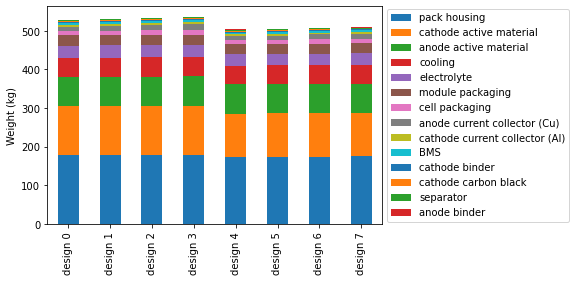

In [14]:
#Plot of the results
import os
def dataframe_components (result_dict, path_comp_type_linkage=None, save=True, name=None):
    """ Returns material content by component group type"""   
    path = os.path.abspath ('..\\batt_sust_model\data\component_type_linkage.xlsx')
    df_types = pd.read_excel(path, index_col='component')
    result = result_dict['material_content_pack']
    df_types[name] = df_types.index.map(result).fillna(0)
    df_types = df_types[(df_types != 0).all(1)]
    df_types = df_types.groupby(['component_type', 'part_off']).sum()
    df_types.sort_values(by='part_off', ascending=True, inplace=True)
    df_types = df_types.reset_index(level=[1])
    df_types.drop('part_off', axis=1, inplace=True)
    return df_types

df_list = [dataframe_components(result_dict_all[x], name=x) for x in result_dict_all.keys()]
df = pd.concat(df_list, axis=1).T.set_axis([f'design {x}' for x in range(8)])
df.sort_values(by=list(df.index)[0], axis=1, ascending=False).plot.bar(stacked=True)
plt.ylabel('Weight (kg)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [15]:
#Export results to excel
bd.export_to_excel(result_dict_all, overwrite=True)